# Decision Tree Classifier – Personality Prediction

This notebook trains and evaluates a Decision Tree model to classify personality (Extrovert vs Introvert) based on behavioral features.


In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


## Load and Prepare Dataset
Convert categorical features to binary values for modeling.


In [4]:
df = pd.read_csv("personality_datasert.csv")
df["Stage_fear"] = np.where(df["Stage_fear"] == "Yes", 1, 0)
df["Drained_after_socializing"] = np.where(df["Drained_after_socializing"] == "Yes", 1, 0)
df["Personality"] = np.where(df["Personality"] == "Extrovert", 1, 0)


## Split into Train and Test Sets
We'll use the first 2500 samples for training and the rest for testing.


In [5]:
train = df[:2500]
test = df[2500:]

X_train = train.drop(columns=["Personality", "Time_spent_Alone", "Going_outside", "Post_frequency"])
X_test = test.drop(columns=["Personality", "Time_spent_Alone", "Going_outside", "Post_frequency"])
y_train = train["Personality"]
y_test = test["Personality"]


## Train Decision Tree Classifier (No Constraints)
We first train a fully grown tree to see how it performs.


In [6]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.93      0.91       175
           1       0.94      0.92      0.93       225

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



## Visualize the Full Tree
This can get large, but it's useful to understand the branching structure.


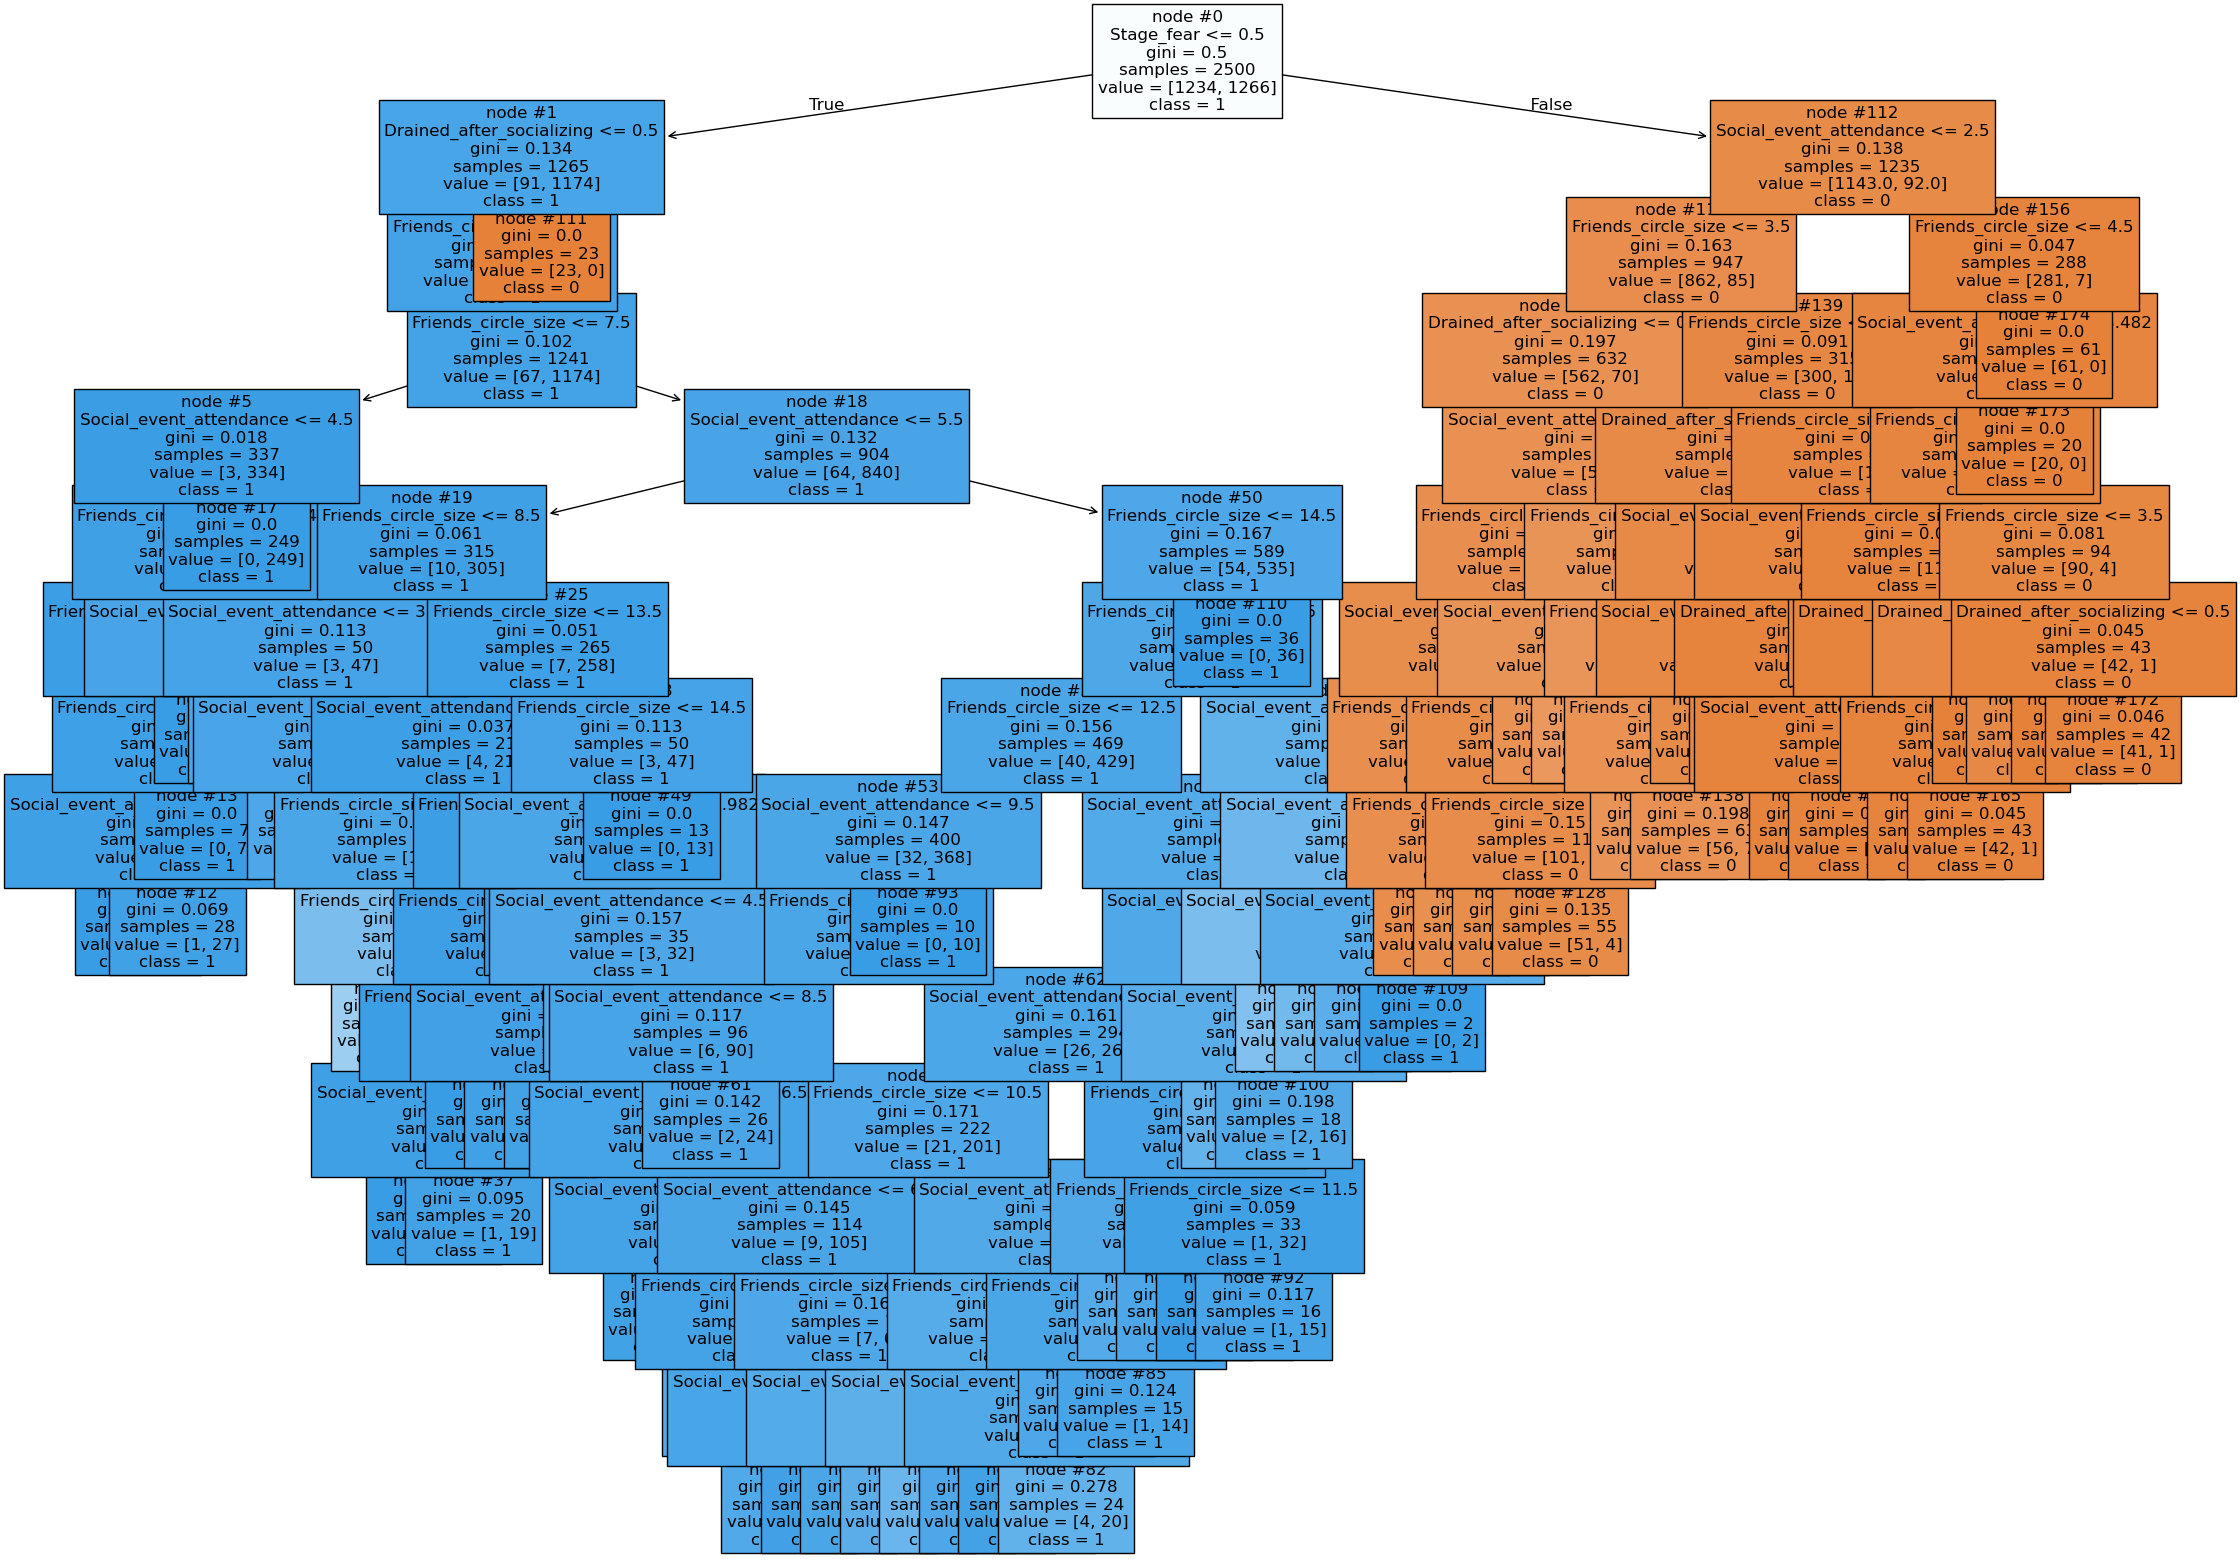

In [7]:
plt.figure(figsize=(26, 20))
plot_tree(model, filled=True, feature_names=X_test.columns, class_names=model.classes_.astype(str), fontsize=12, node_ids=True)
plt.show()


## Feature Importances
Understand which features the tree used most to make decisions.


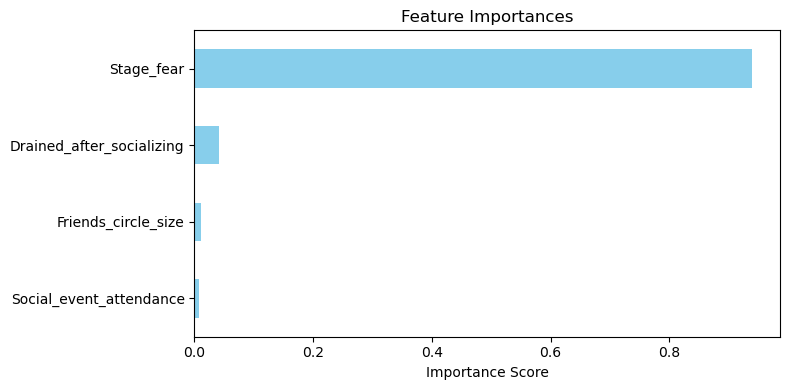

In [8]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
feat_imp.plot(kind='barh', color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Misclassification Node Analysis
Identify which nodes have the most errors.


In [9]:
node_ids = model.apply(X_test)
misclassified = (y_pred != y_test)

df_analysis = pd.DataFrame({
    'node': node_ids,
    'y_true': y_test,
    'y_pred': y_pred,
    'wrong': misclassified
})

node_summary = df_analysis.groupby('node').agg(
    total=('wrong', 'count'),
    wrong=('wrong', 'sum')
)
node_summary['error_rate'] = node_summary['wrong'] / node_summary['total']
node_summary_sorted = node_summary.sort_values(by='wrong', ascending=False)
print(node_summary_sorted)


      total  wrong  error_rate
node                          
135      12      5    0.416667
130      11      3    0.272727
146       9      3    0.333333
91        5      2    0.400000
70        7      2    0.285714
...     ...    ...         ...
78        2      0    0.000000
79        4      0    0.000000
82        5      0    0.000000
88        3      0    0.000000
174       4      0    0.000000

[73 rows x 3 columns]


## Retrain with Pruning (max_depth = 5, min_samples_leaf = 100)
We prune the tree to reduce overfitting.


In [10]:
X_train = train.drop(columns=["Personality"])
X_test = test.drop(columns=["Personality"])
y_train = train["Personality"]
y_test = test["Personality"]

model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.89      0.89       175
           1       0.92      0.92      0.92       225

    accuracy                           0.91       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.91      0.91      0.91       400



## Visualize the Pruned Tree
This version should be smaller and more generalizable.


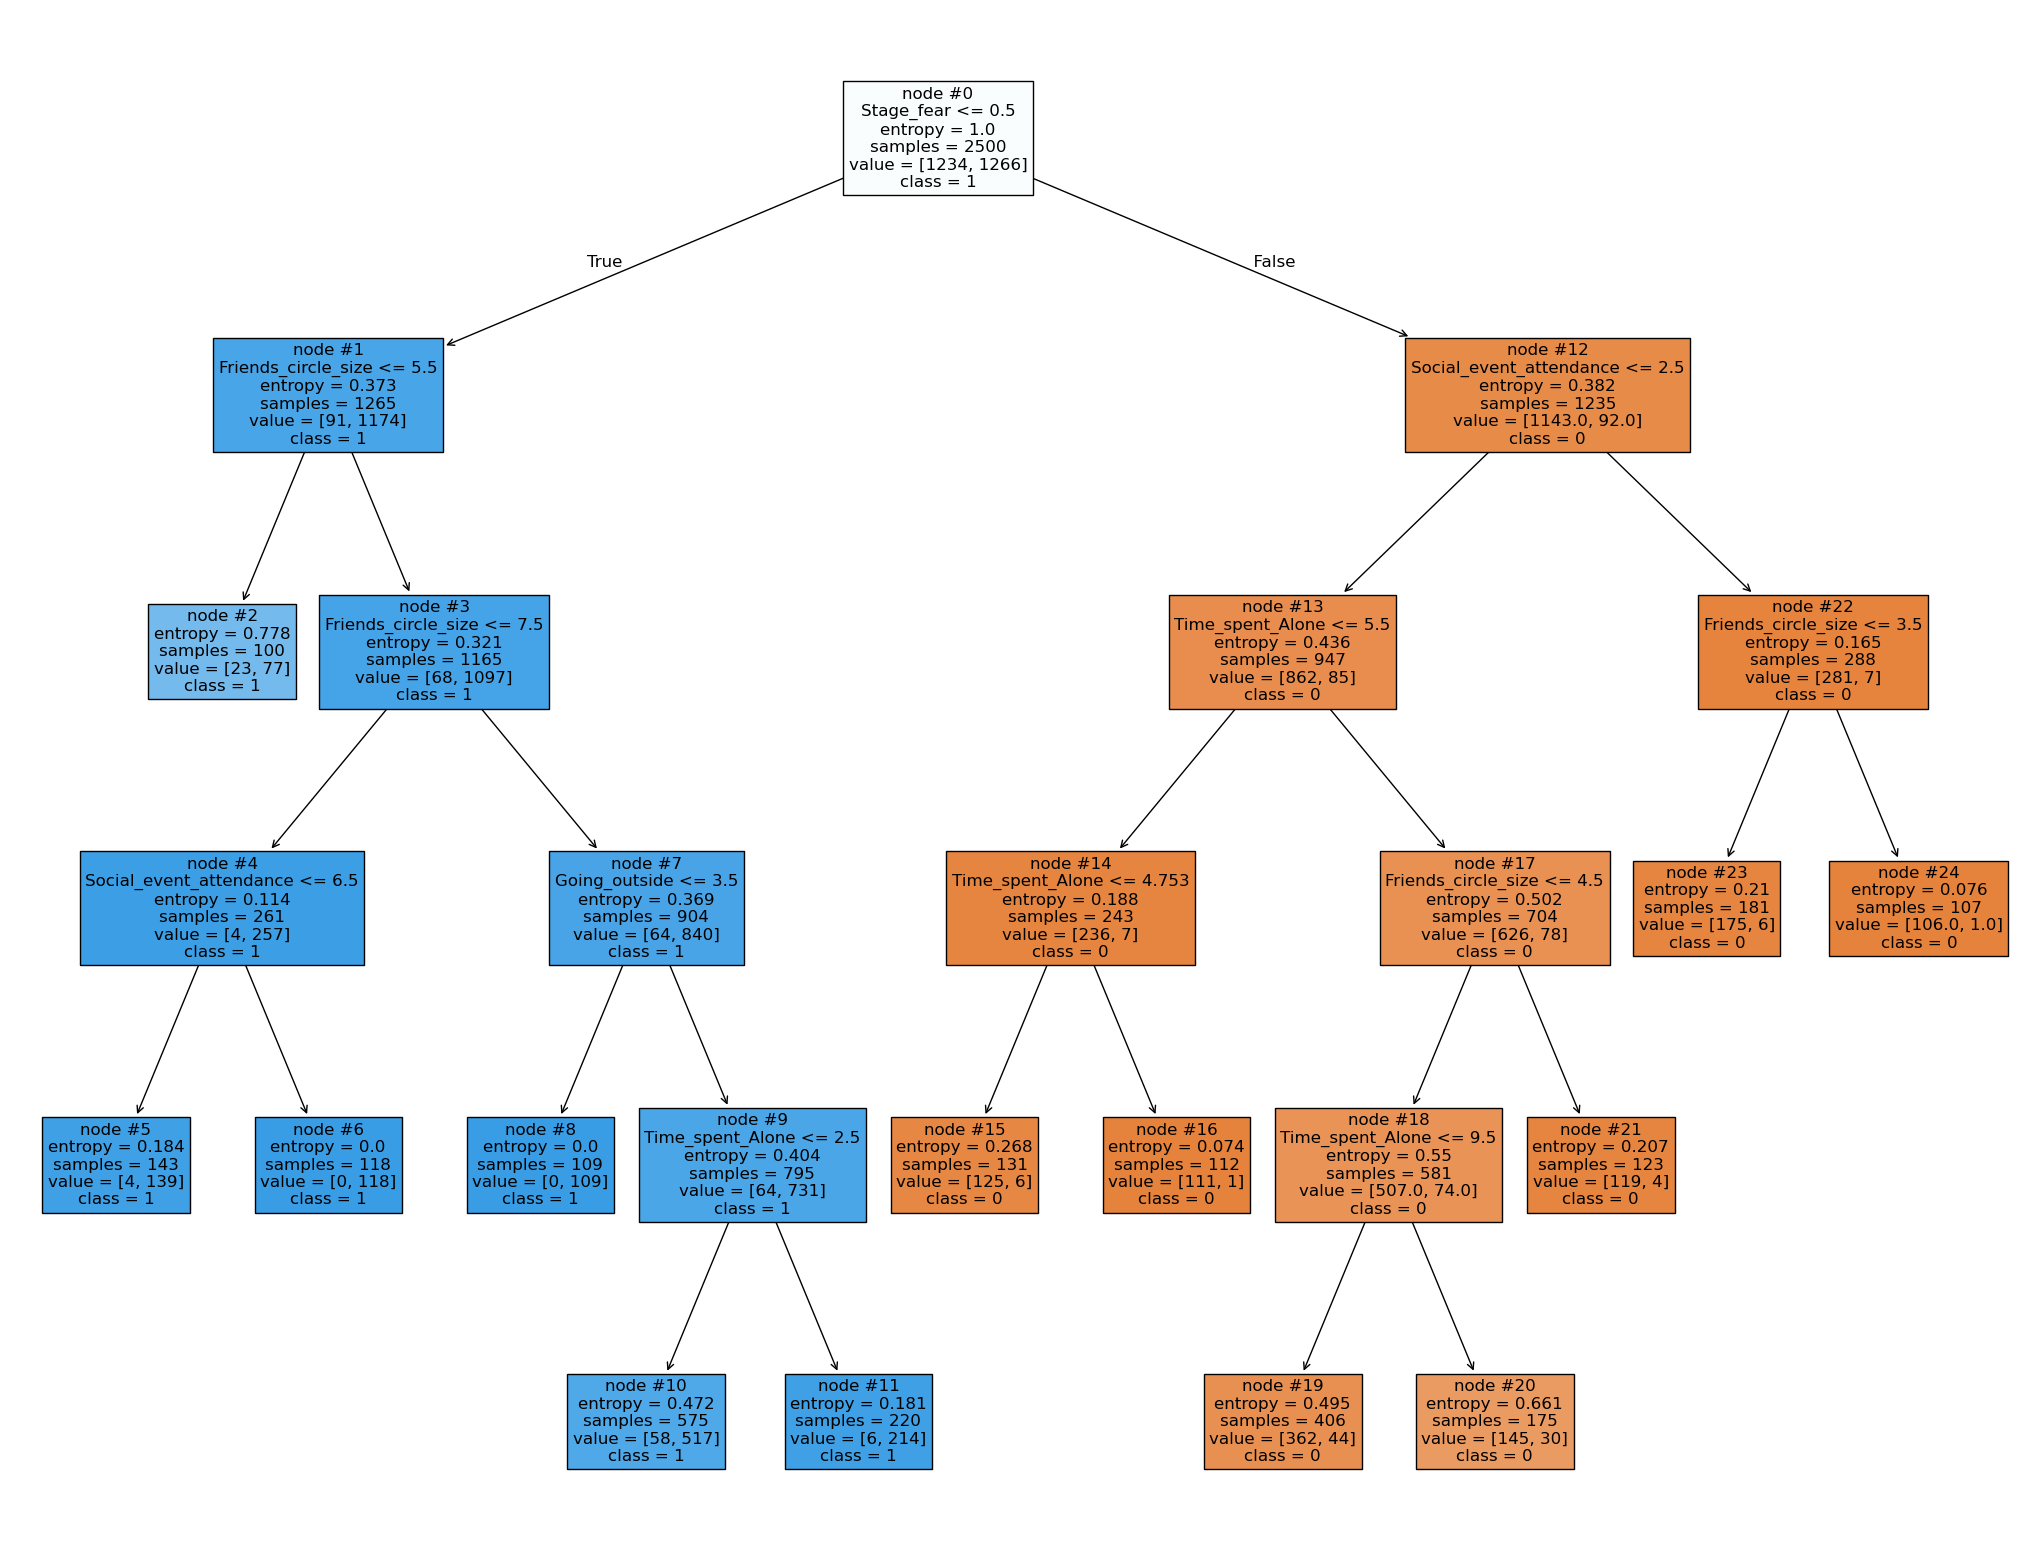

In [11]:
plt.figure(figsize=(26, 20))
plot_tree(model, filled=True, feature_names=X_test.columns, class_names=model.classes_.astype(str), fontsize=12, node_ids=True)
plt.show()


## Feature Importances (Pruned Tree)
Compare feature usage after pruning.


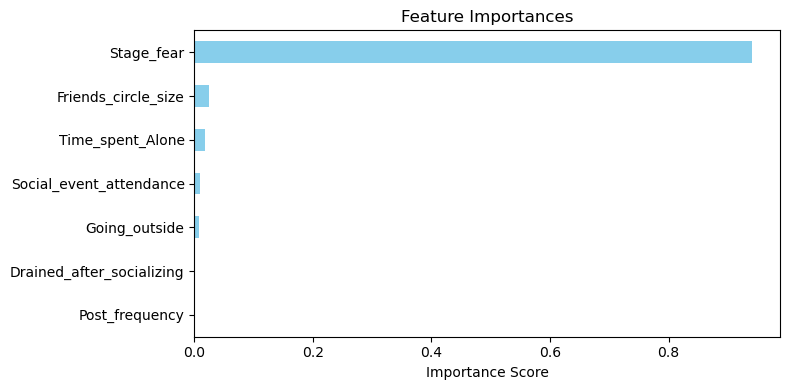

In [12]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
feat_imp.plot(kind='barh', color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Misclassification Node Summary (Pruned Tree)
Even with pruning, it's important to inspect where the model still struggles.


In [13]:
node_ids = model.apply(X_test)
misclassified = (y_pred != y_test)

df_analysis = pd.DataFrame({
    'node': node_ids,
    'y_true': y_test,
    'y_pred': y_pred,
    'wrong': misclassified
})

node_summary = df_analysis.groupby('node').agg(
    total=('wrong', 'count'),
    wrong=('wrong', 'sum')
)
node_summary['error_rate'] = node_summary['wrong'] / node_summary['total']
node_summary_sorted = node_summary.sort_values(by='wrong', ascending=False)
print(node_summary_sorted)


      total  wrong  error_rate
node                          
10       75     12    0.160000
19       51     11    0.215686
20       34      8    0.235294
2        25      7    0.280000
5        27      0    0.000000
6        23      0    0.000000
8        42      0    0.000000
11       33      0    0.000000
15       16      0    0.000000
16       19      0    0.000000
21       19      0    0.000000
23       26      0    0.000000
24       10      0    0.000000
